# Credit card fraud detection

Data comes from https://www.kaggle.com/mlg-ulb/creditcardfraud and concerns credit card transactions details associated with information whether a given transaction was fraudulent or not. The main idea is to get insight from the data and build a predictive model to **detect fraudulent transactions**.

# Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_precision_recall_curve, recall_score, plot_roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

sns.set()

In [2]:
DATA_PATH = '../data/creditcard.csv'

df = pd.read_csv(DATA_PATH)

In [3]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

Time is expressed in seconds since first transaction in the dataset. We change it into hour of the day.

In [4]:
df.Time = df.Time%86400

# Model

### Dataset preparation

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), 
                                                    df.Class, 
                                                    stratify=df.Class, 
                                                    random_state=42,
                                                    test_size=0.2)

In [6]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
x_downsampled, y_downsampled = RandomUnderSampler().fit_resample(x_train, y_train)

In [8]:
x_oversampled, y_oversampled = SMOTE(sampling_strategy=0.1).fit_resample(x_train, y_train)

In [9]:
x_oversampled, y_oversampled = RandomUnderSampler().fit_resample(x_oversampled, y_oversampled)

In [10]:
y_downsampled.value_counts()

1    394
0    394
Name: Class, dtype: int64

In [11]:
y_oversampled.value_counts()

1    22745
0    22745
Name: Class, dtype: int64

### Metrics

As we'd like to detect frauds, denoted by class 1, the situation we want to avoid is predicting a fraud as a normal transaction (FN). In this case, the metric we will try to maximize is $\text{recall}=\frac{TP}{TP+FN}$. It is especially important while building model for imbalanced data.

### Logistic regression

In [12]:
np.random.seed(42)

In [13]:
logistic_regression_downsampled = LogisticRegression()
logistic_regression_oversampled = LogisticRegression()

In [14]:
logistic_regression_downsampled_scores = cross_validate(logistic_regression_downsampled,
                                                         x_downsampled, 
                                                         y_downsampled, 
                                                         cv=5,
                                                         scoring=('recall', 'accuracy'))

logistic_regression_oversampled_scores = cross_validate(logistic_regression_oversampled,
                                                         x_oversampled, 
                                                         y_oversampled, 
                                                         cv=5,
                                                         scoring=('recall', 'accuracy'))

In [15]:
logistic_regression_downsampled_scores['test_recall'].mean()

0.9187925998052581

In [16]:
logistic_regression_oversampled_scores['test_recall'].mean()

0.925390195647395

In [17]:
logistic_regression_downsampled.fit(x_downsampled, y_downsampled)
logistic_regression_oversampled.fit(x_oversampled, y_oversampled)

LogisticRegression()

### Random Forest

In [18]:
random_forest_params = {
    'n_estimators':[10, 50, 100],
    'max_depth':[8, 9, 10, 11, 12]
}
random_forest_downsampled = GridSearchCV(
    RandomForestClassifier(), 
    random_forest_params, 
    scoring=('recall')
)
random_forest_oversampled = GridSearchCV(
    RandomForestClassifier(), 
    random_forest_params, 
    scoring=('recall')
)

In [19]:
%%time
random_forest_downsampled.fit(x_downsampled, y_downsampled)
random_forest_oversampled.fit(x_downsampled, y_downsampled)

Wall time: 31.6 s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'n_estimators': [10, 50, 100]},
             scoring='recall')

In [20]:
random_forest_downsampled.best_score_, random_forest_oversampled.best_score_

(0.9010710808179164, 0.9010386238234339)

### XGBoost

In [21]:
xgboost_params = {
    'n_estimators':[10, 50, 100],
    'max_depth':[8, 9, 10, 11, 12]
}
xgboost_downsampled = GridSearchCV(
    XGBClassifier(), 
    xgboost_params, 
    scoring=('recall')
)
xgboost_oversampled = GridSearchCV(
    XGBClassifier(), 
    xgboost_params, 
    scoring=('recall')
)

In [22]:
%%time
xgboost_downsampled.fit(x_downsampled, y_downsampled)
xgboost_oversampled.fit(x_downsampled, y_downsampled)

Wall time: 28.4 s


GridSearchCV(estimator=XGBClassifier(),
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'n_estimators': [10, 50, 100]},
             scoring='recall')

In [23]:
xgboost_downsampled.best_score_, xgboost_oversampled.best_score_

(0.9213242453748782, 0.9213242453748782)

### Validation

In [24]:
models = (
    logistic_regression_downsampled,
    random_forest_downsampled.best_estimator_,
    xgboost_downsampled.best_estimator_,
    logistic_regression_oversampled,
    random_forest_oversampled.best_estimator_,
    xgboost_oversampled.best_estimator_
)

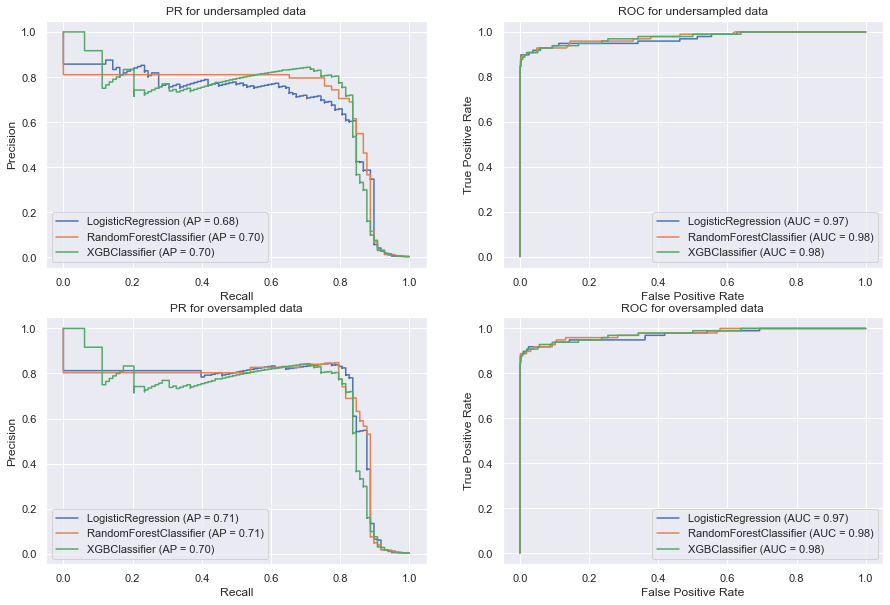

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for model in models[:3]:
    plot_precision_recall_curve(model, x_test, y_test, ax=ax[0,0])
    plot_roc_curve(model, x_test, y_test, ax=ax[0,1])
ax[0,0].set_title('PR for undersampled data')
ax[0,1].set_title('ROC for undersampled data')
for model in models[3:]:
    plot_precision_recall_curve(model, x_test, y_test, ax=ax[1,0])
    plot_roc_curve(model, x_test, y_test, ax=ax[1,1])
ax[1,0].set_title('PR for oversampled data')
ax[1,1].set_title('ROC for oversampled data')
plt.show()

As the AUPR and AUROC scores are similar for under- and oversampling, we choose model fitted with undersampled data, so that we don't unnecessarily use artificially created samples.

### PR Curve

In [32]:
final_model = random_forest_downsampled.best_estimator_

In [33]:
preds = final_model.predict_proba(x_test)

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])

In [35]:
pr = pd.DataFrame(
    {
        'precision':precision,
        'recall':recall,
        'threshold':list(thresholds)+[1]
    }
)

In [36]:
fig_thresh = px.line(
    pr,
    x='recall',
    y='precision',
    text='threshold',
    title='PR curve for final model',
    width=700, height=500
)
fig_thresh.show()

While searching for the highest recall score, we would like to have decent value of precision score. Decision about cut-off point highly depends on the specific task.